COMP5329 – Deep Learning
Assignment 1
Team: 
-	vyun8699 - 530454874
-	gzha9095 – [student number]

Code penalties:
- well organized, commented, documented [5]
- Badly written code [-20]
- Not including instructions on how to run code (ie. readme.txt) [-30]

In [133]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.metrics import classification_report, confusion_matrix 

## Exploratory Data Analysis

In [134]:
# load dataset
original_train_data = np.load('Assignment1-Dataset/train_data.npy')
original_train_label = np.load('Assignment1-Dataset/train_label.npy')
original_test_data = np.load('Assignment1-Dataset/test_data.npy')
original_test_label = np.load('Assignment1-Dataset/test_label.npy')

print('length of training data:', len(original_train_label))
print('length of test data:', len(original_test_label))

length of training data: 50000
length of test data: 10000


class 0: count: 5000, min:-22.08, max:25.58, med:0.01, std:1.26
class 1: count: 5000, min:-22.07, max:24.18, med:-0.01, std:1.24
class 2: count: 5000, min:-21.40, max:25.30, med:-0.00, std:1.09
class 3: count: 5000, min:-21.73, max:23.17, med:-0.00, std:1.22
class 4: count: 5000, min:-21.82, max:21.92, med:-0.00, std:1.02
class 5: count: 5000, min:-19.03, max:23.18, med:-0.00, std:1.19
class 6: count: 5000, min:-23.42, max:23.64, med:-0.00, std:1.09
class 7: count: 5000, min:-21.56, max:23.27, med:-0.00, std:1.14
class 8: count: 5000, min:-21.88, max:23.23, med:0.01, std:1.18
class 9: count: 5000, min:-22.77, max:22.20, med:-0.00, std:1.22


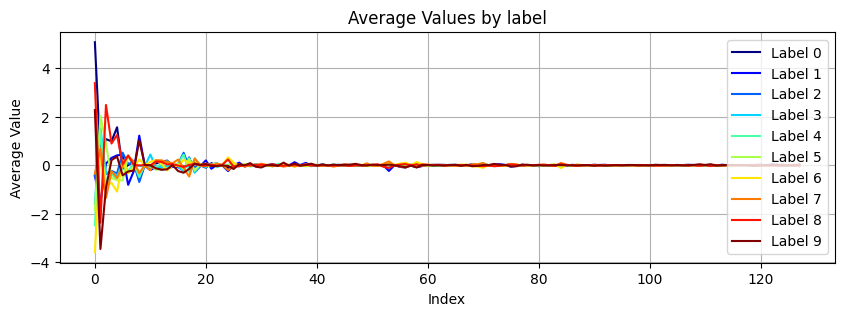

In [135]:
# training dataset is distributed equally
unique_values, counts = np.unique(original_train_label, return_counts = True)

collection = {}
    
for label in unique_values:
    label_indices = np.where(original_train_label == label)[0]
    class_data = original_train_data[label_indices]
    collection[label] = {'count': len(class_data),
                         'min': np.min(class_data),
                         'max': np.max(class_data),
                         'med': np.median(class_data),
                         'std': np.std(class_data),
                         'avg_val': np.mean(class_data, axis = 0)
    }

for label in unique_values:
    print(f'class {label}: count: {collection[label]["count"]}, min:{collection[label]["min"]:.2f}, max:{collection[label]["max"]:.2f}, med:{collection[label]["med"]:.2f}, std:{collection[label]["std"]:.2f}')

num_classes = len(collection)
colors = plt.cm.jet(np.linspace(0, 1, num_classes))  # Using the jet colormap, but you can choose others

plt.figure(figsize=(10, 3))
for i, (label, stats) in enumerate(collection.items()):
    avg_vals = stats['avg_val']  # Assuming this is a list of 128 average values
    indices = np.arange(len(avg_vals))  # Indices from 0 to 127
    plt.plot(indices, avg_vals, color=colors[i], label=f'Label {label}')

plt.title('Average Values by label')
plt.xlabel('Index')
plt.ylabel('Average Value')
plt.legend(loc='right')
plt.grid(True)
#plt.tight_layout()
plt.show()


## Pre-processing

In [136]:
# normalize dataset using train statistics
train_mean = np.mean(original_train_data)
train_std = np.std(original_train_data)
adj_train_data = (original_train_data - train_mean) / train_std
adj_test_data = (original_test_data - train_mean) / train_std

print(f'mean of adjusted train data: {np.mean(adj_train_data)}, std dev: {np.std(adj_train_data)}')

mean of adjusted train data: 1.2286838213526608e-17, std dev: 1.0000000000000004


In [137]:
# resize and shuffle dataset

def resize_and_shuffle(input_data, input_label, proportion, random_state = None):
    '''
    resizes dataset by multiplying against proportion (0 to 1) and shuffle
    
    input:
    - input_data: array of train or test data as provided
    - input_label: array of train or test label as provided
    - propotion: float, proportion of data to be used
    - random_state: seed for randomizer, use for replicability 
    output:
    - output_data: shuffled data with length of proportion * len(input_data)
    - output_label: shuffled label with length of proportion * len(input_label)
    Notes:
    - pairs of (output_data, output_label) will still match as the index used is matched
    Example command:
    - resize_and_shuffle(original_train_data, original_train_label), proportion = 1, random_state = 42)
    '''
    
    #instantiate output list
    output_data = []
    output_label = []
    
    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)
    
    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion*len(label_indices)), replace=False)
        output_data.extend(input_data[selected_indices])
        output_label.extend(input_label[selected_indices])
    
    output_data = np.array(output_data)
    output_label = np.array(output_label)

    #reshuffle data because for some reason everything is grouped by class again
    shuffled_indices = np.arange(len(output_data))
    rs_generator.shuffle(shuffled_indices)
    output_data = output_data[shuffled_indices]
    output_label = output_label[shuffled_indices]
    
    #print output
    print(f'RESIZE AND SHUFFLE:')
    print(f'random_state: {random_state}, input_data: {output_data.shape}, output_data: {output_label.shape}')
    
    return output_data, output_label

In [138]:
# shuffle and train val split (and shuffle again)

def train_val_split(input_data, input_label, proportion = 0.8, random_state = None):
    '''
    train val split by a value of (proportion : 1-proportion) and shuffle
    
    input:
    - input_data: array of train data as provided
    - input_label: array of train label as provided
    - propotion: float, proportion of data to be assigned in train
    - random_state: seed for randomizer, use for replicability 
    output:
    - train_data: shuffled data with length of proportion * len(input_data)
    - tran_label: shuffled label with length of proportion * len(input_label)
    - val_data: shuffled data not included in train_data
    - val_label: shuffled label not included in train_label
    Notes:
    - pairs of (output_data, output_label) will still match as the index used is matched
    Example command:
    - 80:20 train val split >>> train_val_split(train_data, train_label), proportion = 0.8, random_state = 42)
    '''
    #instantiate output lists
    train_data, train_label, val_data, val_label = [],[],[],[]

    #loop over unique labels and populate output lists
    unique_labels = np.unique(input_label)
    rs_generator = np.random.RandomState(random_state)

    for label in unique_labels:
        label_indices = np.where(input_label == label)[0]
        selected_indices = rs_generator.choice(label_indices, size=int(proportion * len(label_indices)), replace=False)
        
        # populate lists. Anything that doesn't go to train, goes to val
        train_data.extend(input_data[selected_indices])
        train_label.extend(input_label[selected_indices])
        val_indices = np.setdiff1d(label_indices, selected_indices)
        val_data.extend(input_data[val_indices])
        val_label.extend(input_label[val_indices])

    #create arrays
    train_data = np.array(train_data)
    train_label = np.array(train_label)
    val_data = np.array(val_data)
    val_label = np.array(val_label)

    # shuffle train data again for good measure
    train_shuffle_indices = np.arange(len(train_data))
    rs_generator.shuffle(train_shuffle_indices)
    train_data = train_data[train_shuffle_indices]
    train_label = train_label[train_shuffle_indices]
    
    # shuffle val data  again for good measure
    val_shuffle_indices = np.arange(len(val_data))
    rs_generator.shuffle(val_shuffle_indices)
    val_data = val_data[val_shuffle_indices]
    val_label = val_label[val_shuffle_indices]
    
    head_length = 5

    #prints
    print(f'TRAIN AND VAL SPLIT:')
    print(f'length of train data: {len(train_data)}, train label: {len(train_label)}, head: {train_label[0:head_length].T}')
    print(f'length of val data: {len(val_data)}, val label: {len(val_label)}, head: {val_label[0:head_length].T}')
    
    return train_data, train_label, val_data, val_label

RESIZE AND SHUFFLE:
random_state: 42, input_data: (20000, 128), output_data: (20000, 1)
TRAIN AND VAL SPLIT:
length of train data: 16000, train label: 16000, head: [[1 6 0 9 7]]
length of val data: 4000, val label: 4000, head: [[6 2 5 0 9]]


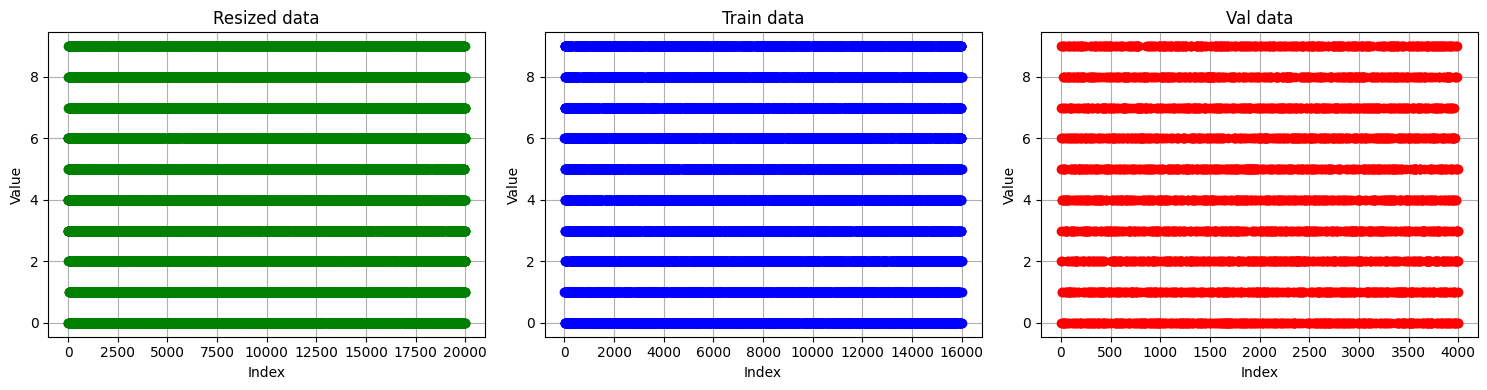

In [139]:
# test resize_and_shuffle and train_val_split
data_proportion = 0.4 # 0.4 x 50,000 = 20,000
train_proportion = 0.8 # 0.8 x 20,000 = 16,000 in train_data
random_state = 42
input_check, output_check = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data_check, train_label_check, val_data_check, val_label_check =train_val_split(input_check, output_check, proportion = train_proportion, random_state = 42)

# plot results, as long as data seems spread well, then the function works
fig, axs = plt.subplots(1, 3, figsize=(15, 4))  # 1 row, 2 columns

# Plot for training data
axs[0].plot(output_check, marker='o', linestyle ='', color = 'green')
axs[0].set_title('Resized data')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Value')
axs[0].grid(True)

# Plot for training data
axs[1].plot(train_label_check, marker='o', linestyle ='', color = 'blue')
axs[1].set_title('Train data')
axs[1].set_xlabel('Index')
axs[1].set_ylabel('Value')
axs[1].grid(True)

# Plot for validation data
axs[2].plot(val_label_check, marker='o', linestyle ='', color = 'red')
axs[2].set_title('Val data')
axs[2].set_xlabel('Index')
axs[2].set_ylabel('Value')
axs[2].grid(True)

plt.tight_layout()
plt.show()

In [140]:
# plot results and print scores

def plot_loss(input_data, batch_size, epoch_loss):
   
   #plot loss
   step = (len(input_data) / batch_size) 
   epoch_x_values = np.arange(step, (len(epoch_loss) + 1) * step, step)
   
   plt.figure(figsize=(15,5))
   plt.title('Cross entropy loss')

   # Plot epoch_loss as a red line
   plt.plot(epoch_x_values, epoch_loss, 'r-', label='Epoch loss')  # Red line for epoch loss

   plt.xlabel('Batches')
   plt.ylabel('Loss')
   plt.legend()
   plt.show()

def plot_loss_train_val(train_losses, val_losses, val_loss_interval=10, show_val=True):
    """
    Plots the training and validation losses.

    input:
    - train_losses: List of training losses.
    - val_losses: List of validation losses.
    - val_loss_interval: Interval at which validation losses were calculated (default is 10).
    - show_val: toggle to include/exclude val_losses in plot
    """
    epochs = range(1, len(train_losses) + 1)
    val_epochs = [i * val_loss_interval for i in range(1, len(val_losses) + 1)]

    plt.plot(epochs, train_losses, 'bo-', label='Training loss')
    if show_val:
      plt.plot(val_epochs, val_losses, 'ro-', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
   
def print_scores(train_data, train_label, test_data, test_label, model):

   """
    Calculate training and testing scores based on model
   """

   print('train scores:')
   print(classification_report(train_label, model.predict(train_data)))
   
   print('test scores')
   print(classification_report(test_label, model.predict(test_data)))

In [141]:
# modules
'''
- More than one hidden layer [5] >>>> DONE
- ReLU activation [5] >>>> DONE
- Momentum in SGD [5] >>>> ONGOING
- Softmax and cross entropy loss [5] >>>> DONE
- Mini-batch training [5] >>>> DONE
- Weight decay [5] 
- Dropout [5]
- Batch normalization [5]
- Other advanced ops (e.g. GELU, Adam) [5] <<< justify

NOTE: need to show hyperparameter tuning and runtimes
'''

'\n- More than one hidden layer [5] >>>> DONE\n- ReLU activation [5] >>>> DONE\n- Momentum in SGD [5] >>>> ONGOING\n- Softmax and cross entropy loss [5] >>>> DONE\n- Mini-batch training [5] >>>> DONE\n- Weight decay [5] \n- Dropout [5]\n- Batch normalization [5]\n- Other advanced ops (e.g. GELU, Adam) [5] <<< justify\n\nNOTE: need to show hyperparameter tuning and runtimes\n'

In [142]:
class Activation(object):
    
    '''
    Activation objects and their derivatives used in our MLP. This class contains:
    - tanh
    - sigmoid
    - relu
    - softmax

    Example command:
    - relu activation function >>> Activation("relu")
    '''
    #tanh
    def __tanh(self, x):
        return np.tanh(x)
    def __tanh_deriv(self, a):
        # a = np.tanh(x)   
        return 1.0 - a**2
    
    #sigmoid/logistic
    def __logistic(self, x):
        return 1.0 / (1.0 + np.exp(-x))
    def __logistic_deriv(self, a):
        # a = logistic(x) 
        return  a * (1 - a )
    
    #relu
    def __relu(self, x):
        return np.maximum(0,x)
    def __relu_deriv(self, a):
        return np.where(a>0,1,0)
    
    #softmax
    def __softmax(self,x): 
        ''' 
        softmax is applied to the output layer to calculate probabilities of each classes.
        argmax of exponential calculation is used in MLP to pick the predicted class with highest probability in the softmax layer.
        np.max is subtracted from the exponential calculation to guard against overflow issue.
        Thus the largest value of the exponential calculation is exp(0) = 1
        '''
        if np.isnan(x).any() or np.isinf(x).any():
            print("Detected NaN or Inf in x:", x)
        exps = np.exp( x -np.max(x, axis =-1, keepdims = True))
        
        return exps / np.sum(exps, axis =-1, keepdims = True) +1e-9

    def __softmax_deriv(self,yhat, y_one_hot):
        '''
        gradient is approximated as the difference of predicted and true values.
        softmax gradient is not used in this model as softmax is only called in the output layer.
        '''
        return yhat - y_one_hot 

    def __init__(self,activation='tanh'):
        if activation == 'logistic':
            self.f = self.__logistic
            self.f_deriv = self.__logistic_deriv
        elif activation == 'tanh':
            self.f = self.__tanh
            self.f_deriv = self.__tanh_deriv
        elif activation == 'relu':
            self.f = self.__relu
            self.f_deriv = self.__relu_deriv
        elif activation == 'softmax':
            self.f = self.__softmax
            self.f_deriv = self.__softmax_deriv

In [143]:
class HiddenLayer(object):    
    
    '''
    Hidden layer objects for our MLP. This class contains:
    - forward
    - backward
    - momentum
    - weight decay
    - batchnorm_forward
    - batchnorm_backward
    - batchnorm_update

    Example command:
    - relu layer with 10 and 5 dimension input and output >>> HiddenLayer(10, 5, activation="relu")
    '''
    
    def __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None):
        """
        Fully connected hidden layer with default relu activation, overwrittable when HiddenLayer is called.
        :Param n_in:
        :Param n_out:
        :Param activation_last_layer:
        :Param activation:
        :Param W: weights, initialized with Xavier normalized initiation.
        :Param b: bias, initialized as zeros.

        """
        self.input=None
        self.activation=Activation(activation).f
        
        # activation deriv of last layer
        self.activation_deriv=None
        if activation_last_layer:
            self.activation_deriv=Activation(activation_last_layer).f_deriv

        # we randomly assign small values for the weights as the initiallization
        self.W = np.random.uniform(
                low=-np.sqrt(6. / (n_in + n_out)),
                high=np.sqrt(6. / (n_in + n_out)),
                size=(n_in, n_out)
        )


        # we set the size of bias as the size of output dimension
        self.b = np.zeros(n_out,)
        
        # we set the size of weight gradation as the size of weight
        self.grad_W = np.zeros(self.W.shape)
        self.grad_b = np.zeros(self.b.shape)
        
        #initialize momentum here
        self.V_W = np.zeros(self.W.shape)
        self.V_b = np.zeros(self.b.shape)

        #initialize inverted dropout to be used in forward and backward
        self.dropout_mask = None

    # the forward and backward progress (in the hidden layer level) for each training epoch
    # please learn the week2 lec contents carefully to understand these codes. 
    def forward(self, input, dropout_rate =0.0, is_train = True):
        '''
        :type input: numpy.array
        :param input: a symbolic tensor of shape (n_in,)
        '''

        lin_output = np.dot(input, self.W) + self.b
        self.output = (
            lin_output if self.activation is None
            else self.activation(lin_output)
        )
        
        #dropout function only called once at forward which updates the mask
        self.dropout(is_train, dropout_rate)
        #print(f'mask at forward: {self.dropout_mask}')
                
        self.input=input

        return self.output
    
    #updated to handle softmax at output layer
    def backward(self, delta):         
        '''
        Note that the output_layer toggle is not used as backward pass calculation is uniform everywhere
        Note backward calculates grad_W and grad_b for the HiddenLayer object, while the iterator is housed in MLP
        '''
        #print(f'mask at backward: {self.dropout_mask}')

        #multiply with mask to decide which neurons to use
        delta *= self.dropout_mask
        
        self.grad_W = np.dot(np.atleast_2d(self.input).T, np.atleast_2d(delta))
        self.grad_b = np.sum(delta, axis = 0) 
        
        if self.activation_deriv: 
            delta = np.dot(delta, self.W.T) * self.activation_deriv(self.input)

        return delta
    
    def momentum(self, gamma, lr):
        '''
        momentum is housed in HiddenLayer while the iterator in MLP
        '''
        self.V_W = gamma * self.V_W + lr * self.grad_W
        self.V_b = gamma * self.V_b + lr * self.grad_b 

    def weightdecay(self, lr, weight_decay):
        '''
        weight decay is only housed here, calculation based on lecture 4 slide 10, bottom middle
        '''
        self.W += lr * (weight_decay * self.W)

    def dropout(self, is_train, dropout_rate):

        #print(f'dropout function triggered, is_train = {is_train}, dropout_rate = {dropout_rate}')
        
        if is_train and dropout_rate > 0.0:
            self.dropout_mask = (np.random.rand(*self.output.shape) < (1 - dropout_rate)) 
            self.output *= self.dropout_mask
        else:
            self.dropout_mask = np.ones_like(self.output)

In [144]:
class MLP:
    # for initiallization, the code will create all layers automatically based on the provided parameters.     
    def __init__(self, layers, activation=[None,'tanh','softmax']):
        """
        :param layers: A list containing the number of units in each layer. Should be at least two values
        :param activation: The activation function to be used. Can be "logistic" or "tanh"
        """

        # __init__(self,n_in, n_out, activation_last_layer='softmax',activation='relu', W=None, b=None, dropout_rate = 0.0)        
        ### initialize layers
        self.layers=[]
        self.params=[] # this doesnt do anything
        
        self.activation=activation
        for i in range(len(layers) - 1):
            if i == len(layers) - 2:  # Check if it's the last hidden layer
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1], W=np.random.uniform(
                            low=-np.sqrt(6. / (layers[i] + layers[i + 1])),
                            high=np.sqrt(6. / (layers[i] + layers[i + 1])),
                            size=(layers[i], layers[i + 1])).T)
                self.layers.append(hidden_layer)
            else:
                hidden_layer = HiddenLayer(layers[i], layers[i + 1], activation[i], activation[i + 1])
                self.layers.append(hidden_layer)


    # forward progress: pass the information through the layers and out the results of final output layer
    def forward(self,input, dropout_rate =0.0, is_train = True):
        #print(f'dropout rate in MLP.forward: {dropout_rate}')
        for layer in self.layers:
            output=layer.forward(input, dropout_rate, is_train)
            input=output
        return output

    #implement cross entropy, mimic input and output of MSE
    def criterion_cross_entropy(self, y, y_hat, batch_size):
        '''
        shape of y = (1,) <-- a single integer of true class
        shape of y_hat = (10,) <-- values corresponding to each class
        '''
        activation_deriv=Activation(self.activation[-1]).f_deriv
        
        #one hot encode y to match shape of y_hat, value is 0 everywhere, 1 for the positive column
        num_classes = y_hat.shape[1] 
        num_samples = y.shape[0]
        y_one_hot = np.zeros((num_samples,num_classes)) 
        y = y.flatten().astype(int)
        y_one_hot[np.arange(num_samples),y] = 1 

        # calculate loss, add epsilon to avoid log 0
        loss = np.sum(- y_one_hot * np.log(y_hat + 1e-9)) /  batch_size #adjusting loss by batch_size for minibatch
        
        #calculate delta of output layer 
        delta = activation_deriv(y_hat, y_one_hot)

        #return loss and delta
        return loss, delta

    # backward progress  
    def backward(self,delta):
        delta=self.layers[-1].backward(delta)
        for layer in reversed(self.layers[:-1]): #self.layers[:-1] returns the list excluding the last element
            delta = layer.backward(delta)

    # update the network weights after backward.
    # make sure you run the backward function before the update function!  
    # note: added assert for debugging  
    def update(self,gamma, lr, weight_decay):
        for layer in self.layers:
            assert layer.W.shape == layer.grad_W.shape, 'mismatch in W and grad_W shapes'
            assert layer.b.shape == layer.grad_b.shape, f'mismatch in b {layer.b.shape} and grad_b shapes {layer.grad_b.shape}'
            
            #call momentum from HiddenLayer to update V values
            layer.momentum(gamma,lr)
            
            #call weightdecay from hiddenlayer to update V values
            layer.weightdecay(lr, weight_decay)

            #apply adjustments to V_W to W
            layer.W -= layer.V_W
            layer.b -= layer.V_b

    '''minibatch added here. n = 1 is SGD, n = N is batch n = n is minibatch'''
    def getBatch(self, X,y, batch_size):
        
        '''
        output: tuples of (X,y) with length = batch_size
        '''
        #exceptions
        if X.shape[0] != y.shape[0]:
            raise ValueError(f'length of data ({X.shape[0]}) not equal to length of label ({y.shape[0]})')
        if batch_size > X.shape[0]:
            raise ValueError(f'batch_size = {batch_size} > data count: {X.shape[0]}')
        
        #mini batch 
        if batch_size <= X.shape[0]:
            # for loop below drops the last batch, just in case it is too small
            for start_index in range(0, X.shape[0] - batch_size + 1, batch_size):
                end_index = min(start_index + batch_size, X.shape[0])
                #print(f'start_index: {start_index}, end_index: {end_index}')
                #print(f'X:{X[start_index:end_index]}, y:{y[start_index:end_index]}')
                yield X[start_index:end_index], y[start_index:end_index]

    # define the training function
    # it will return all losses within the whole training process.
    def fit(self,X_train,y_train, X_val, y_val, gamma =0.9, learning_rate=0.1, epochs=100, batch_size =1, weight_decay = 0.01, dropout_rate = 0.0, early_stopping =[5,10]):
       
        print('FITTING:')
        print(f'dropout_rate: {dropout_rate}, gamma: {gamma}, learning_rate: {lr}, epochs: {epochs}, batch_size:{batch_size}')
        print(f'size of train: {len(y_train)}, size of val: {len(y_val)}')

        #insert assert for data and label for train and val

        validate_check = len(X_val) > 0 and len(y_val) > 0

        if validate_check is False:
            print('No validation data provided, skipping validation step')

        #instantiate toggles for early_stopping
        is_early_stop = False
        last_validation_loss = float('inf') if validate_check else None
        epoch = 0
        count = 0
        MAX_COUNT = early_stopping[0]
        EVAL_TRIGGER = early_stopping[1]

        # assign X_train and y_train to X and y 
        X=np.array(X_train)
        y=np.array(y_train)
        epoch_losses = []
        val_losses = []
        
        #loop over epochs
        for k in range(epochs):
            #print(f'dropout rate in fit epoch {k}: {dropout_rate}')
            
            print(f'start epoch {k}')
            epoch_loss = self.train_loop(X, y, batch_size, dropout_rate, gamma, learning_rate, weight_decay)
            epoch_losses.append(epoch_loss)

            #implement early stop
            if validate_check and k % EVAL_TRIGGER == 0:
                current_validation_loss = self.eval(X_val, y_val)
                
                if current_validation_loss > last_validation_loss:
                    count += 1

                    if count == MAX_COUNT:
                        print(f'training stopped at epoch {k}!!')
                        is_early_stop = True
                        early_stop_train_score = epoch_loss
                        break
                
                else:
                    last_validation_loss = current_validation_loss
                    count = 0

                if not is_early_stop:
                    val_losses.append(current_validation_loss)
                    
            epoch += 1

        if validate_check and is_early_stop:
            print('Continuing training with train + val data until we hit max epoch or new training score < training score at early stop')
            X_combined = np.concatenate((X_train, X_val))
            y_combined = np.concatenate((y_train, y_val))

            while epoch < epochs:
                epoch_loss = self.train_loop(X_combined, y_combined, batch_size, dropout_rate, gamma, learning_rate, weight_decay)
                epoch_losses.append(epoch_loss)
                
                if epoch_loss < early_stop_train_score:
                    print(f'Combined training loss < last val loss at epoch: {epoch}')
                    break

                epoch +=1

        print(f'end of epoch {k}')

        return epoch_losses, val_losses

    # define the prediction function
    # we can use predict function to predict the results of new data, by using the well-trained network.
    def predict(self, x):
        '''adjusted to account for softmax output layer'''
        x = np.array(x)
        output = np.zeros((x.shape[0], 1))  # Prepare output array to store predicted class labels
        for i in np.arange(x.shape[0]):
            probabilities = self.forward(x[i, :],is_train = False)  # Get the softmax probabilities
            predicted_class = np.argmax(probabilities)  # Choose the class with the highest probability
            output[i] = int(predicted_class)  # Assign the predicted class to the output array
        return output
    
    def eval(self, X_val, y_val):
        #print('eval triggered')
        X_val = np.array(X_val)
        y_val = np.array(y_val)
        yhat_val = self.forward(X_val, is_train=False) # we don't use predict because it will cause issues in criterion cross entropy  
        #print('x')
        val_loss, _ = self.criterion_cross_entropy(y_val,yhat_val, len(y_val))
        #print('end of eval')
        return np.mean(val_loss)
    
    def train_loop(self, X, y, batch_size, dropout_rate, gamma, learning_rate, weight_decay):
        #spits out epoch loss
                    
        total_loss = 0 #sum up batch_losses for every epoch
        batches = 0 #count number of batches, e.g. 1,2,3,4
        #print('y')
        for X_batch, y_batch in self.getBatch(X,y,batch_size):
            #print('x')
            # forward pass
            y_hat = self.forward(X_batch, dropout_rate = dropout_rate, is_train = True)
            #print(y_hat.shape)
            
            # compute loss and gradient
            loss,delta=self.criterion_cross_entropy(y_batch,y_hat, batch_size)

            #backward pass
            self.backward(delta)

            # update
            self.update(gamma, learning_rate, weight_decay)

            #record batch loss in batch losses
            batch_loss = np.mean(loss)
            batches += 1
            total_loss += batch_loss
            #print(f'batches:{batches}')
            
            #print(y_batch)
            #print(f'Epoch: {k}, batch: {batches}, X_batch dim: {X_batch.shape}, y_batch dim: {y_batch.shape}, loss: {loss}')

        epoch_loss = total_loss / batches

        return epoch_loss

RESIZE AND SHUFFLE:
random_state: 42, input_data: (50000, 128), output_data: (50000, 1)
TRAIN AND VAL SPLIT:
length of train data: 40000, train label: 40000, head: [[6 7 8 3 2]]
length of val data: 10000, val label: 10000, head: [[2 7 1 9 6]]
FITTING:
dropout_rate: 0.5, gamma: 0.9, learning_rate: 0.01, epochs: 50, batch_size:100
size of train: 40000, size of val: 10000
start epoch 0
start epoch 1
start epoch 2
start epoch 3
start epoch 4
start epoch 5
start epoch 6
start epoch 7
start epoch 8
start epoch 9
start epoch 10
start epoch 11
start epoch 12
start epoch 13
start epoch 14
start epoch 15
start epoch 16
start epoch 17
start epoch 18
start epoch 19
start epoch 20
start epoch 21
start epoch 22
start epoch 23
start epoch 24
start epoch 25
start epoch 26
start epoch 27
start epoch 28
start epoch 29
start epoch 30
start epoch 31
start epoch 32
start epoch 33
start epoch 34
start epoch 35
start epoch 36
start epoch 37
start epoch 38
start epoch 39
start epoch 40
start epoch 41
start ep

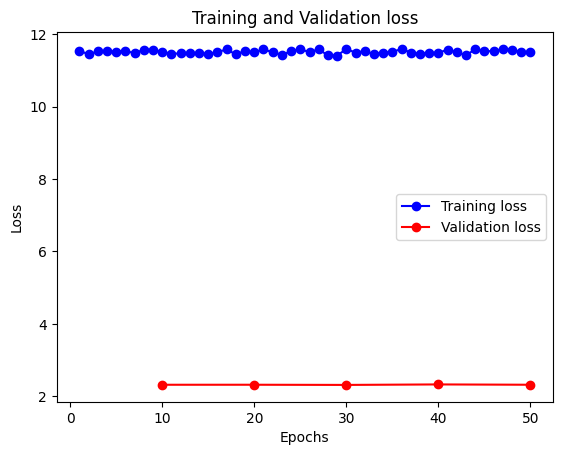

In [151]:
#dropout

# pick data proportion and train val split
data_proportion = 1
random_state = 42
train_proportion = .8
input_data, input_label = resize_and_shuffle(adj_train_data, original_train_label, proportion = data_proportion, random_state = random_state)
train_data, train_label, val_data, val_label = train_val_split(input_data, input_label, proportion = train_proportion, random_state = random_state)

# fit model
nn = MLP([128,64,64,10], [None,'relu','relu','softmax'])

lr = 0.01
epoch_count = 200
gamma = 0.9 #momentum
weight_decay = 0.00 #weight decay
dropout = 0.0
batch_size = 100
early_stopping = [3,10] #max count, eval_trigger, to switch off early stopping, set max count to np.inf

# calculate cross entropy
train_loss, val_loss = nn.fit(train_data, train_label, val_data, val_label, gamma = gamma, learning_rate = lr, epochs = epoch_count, batch_size = batch_size, weight_decay = weight_decay, dropout_rate = dropout, early_stopping = early_stopping)
print(f'train loss:{train_loss[-1]}, val loss: {val_loss[-1] if len(val_loss) >0 else None }')

#plot_results(train_data, train_label, batch_size, train_loss)
plot_loss_train_val(train_loss, val_loss, val_loss_interval=early_stopping[1])

# predict output
#print_scores(train_data, train_label, adj_test_data, original_test_label, nn)

#dropout may not be implemented to last layer before softmax because this restricts the model from propagating fixes upstream
#https://stats.stackexchange.com/questions/299292/dropout-makes-performance-worse


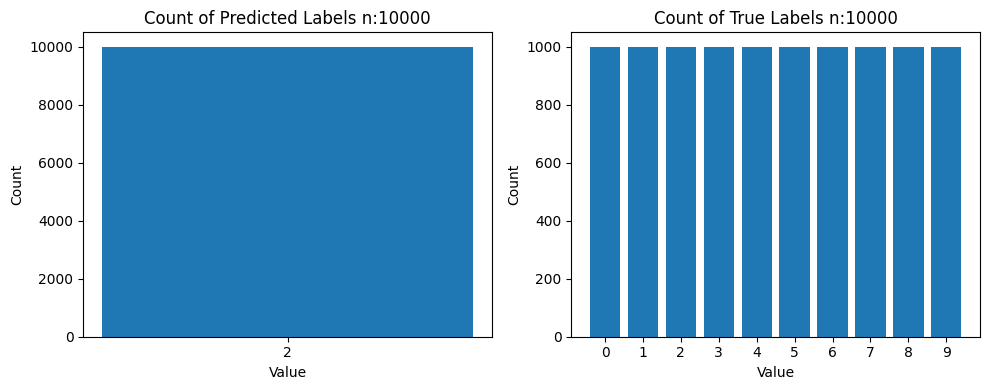

In [152]:
# plot prediction
output = nn.predict(adj_test_data)
output_unique_values, output_counts = np.unique(output, return_counts=True)
true_label_unique_values, true_label_counts = np.unique(original_test_label, return_counts=True)

   
# Set up the matplotlib figure and axes, one for each bar chart
fig, axs = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# Plot for 'output'
axs[0].bar(output_unique_values, output_counts)
axs[0].set_xticks(output_unique_values)
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Count')
axs[0].set_title(f'Count of Predicted Labels n:{len(output)}')

# Plot for 'true_label'
axs[1].bar(true_label_unique_values, true_label_counts)
axs[1].set_xticks(true_label_unique_values)
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Count')
axs[1].set_title(f'Count of True Labels n:{len(original_test_label)}')

plt.tight_layout()  # Adjust the layout to fit both subplots
plt.show()